In [1]:
%matplotlib inline
import sys
from astropy import table
import numpy as np
from pathlib import Path
from matplotlib import colors, cm
import cmocean
import betterplotlib as bpl

bpl.set_style()

In [2]:
home_dir = Path("../").resolve()
data_dir = home_dir / "data"

In [3]:
sys.path.append(str(home_dir / "pipeline"))
import utils

In [4]:
catalogs = []
for galaxy_dir in data_dir.iterdir():
    if galaxy_dir.name == "artificial":
        continue
    cat_name = galaxy_dir / "size" / "final_catalog_final_30_pixels_psf_my_stars_15_pixels_2x_oversampled.txt"
    final_cat = table.Table.read(str(cat_name), format="ascii.ecsv")
    catalogs.append(final_cat)
    
all_catalog = table.vstack(catalogs, join_type="inner")

In [5]:
mask_mass = np.logical_and.reduce(
        [
            all_catalog["reliable_radius"],
            all_catalog['reliable_mass'],
            all_catalog["mass_msun"] > 0,
            all_catalog["mass_msun_max"] > 0,
            all_catalog["mass_msun_min"] > 0,
            all_catalog["mass_msun_min"] <= all_catalog["mass_msun"],
            all_catalog["mass_msun_max"] >= all_catalog["mass_msun"],
            all_catalog["Q_probability"] > 1e-3,
        ]
    )

big_catalog = all_catalog[mask_mass]

In [6]:
def transform_to_log(mean, err_lo, err_hi):
    """
    Take a value and its error and transform this into the value and its error in log

    :param mean: Original value
    :param err_lo: Lower error bar
    :param err_hi: Upper error bar
    :return: log(mean), mean error in log
    """
    log_mean = np.log10(mean)
    log_err_lo = log_mean - np.log10(mean - err_lo)
    log_err_hi = np.log10(mean + err_hi) - log_mean

    return log_mean, 0.5 * (log_err_lo + log_err_hi)

def get_my_masses(catalog):
    """
    Get the masses from my catalog, along with their errors

    :param catalog: Catalog to retrieve the masses from
    :param mask: Mask to apply to the data, to restrict to certain clusters
    :return: Tuple with three elements: mass, lower mass error, upper mass error
    """
    mass = catalog["mass_msun"]
    # mass errors are reported as min and max values
    mass_err_lo = mass - catalog["mass_msun_min"]
    mass_err_hi = catalog["mass_msun_max"] - mass

    return mass, mass_err_lo, mass_err_hi


def get_my_radii(catalog):
    """
    Get the radii from my catalog, along with their errors

    :param catalog: Catalog to retrieve the radii from
    :param mask: Mask to apply to the data, to restrict to certain clusters
    :return: Tuple with three elements: radius, lower radius error, upper radius error
    """
    r_eff = catalog["r_eff_pc"]
    r_eff_err_lo = catalog["r_eff_pc_e-"]
    r_eff_err_hi = catalog["r_eff_pc_e+"]

    return r_eff, r_eff_err_lo, r_eff_err_hi


def get_my_ages(catalog):
    """
    Get the ages from my catalog, along with their errors

    :param catalog: Catalog to retrieve the ages from
    :param mask: Mask to apply to the data, to restrict to certain clusters
    :return: Tuple with three elements: age, lower age error, upper age error
    """
    age = catalog["age_yr"]
    # age errors are reported as min and max values
    age_err_lo = age - catalog["age_yr_min"]
    age_err_hi = catalog["age_yr_max"] - age

    return age, age_err_lo, age_err_hi

In [7]:
# calculate the mean error in log space, will be used for the KDE smothing
log_r_eff, log_r_eff_err = transform_to_log(*get_my_radii(big_catalog))

big_catalog["r_eff_log"] = log_r_eff
big_catalog["r_eff_logerr_smooth"] = 2 * log_r_eff_err  # don't do average, it is too small

# do the same thing for mass and age
log_mass, log_mass_err = transform_to_log(*get_my_masses(big_catalog))

big_catalog["mass_log"] = log_mass
big_catalog["mass_logerr_smooth"] = 2 * log_mass_err  # don't do average, it is too small

log_age, log_age_err = transform_to_log(*get_my_ages(big_catalog))

big_catalog["age_log"] = log_age
big_catalog["age_logerr_smooth"] = 0.2

In [8]:
mask_e = big_catalog["field"] == "ngc7793-e"
mask_w = big_catalog["field"] == "ngc7793-w"
mask_ew = big_catalog["galaxy"] == "ngc7793"

In [9]:
print(np.sum(mask_e))
print(np.sum(mask_w))
print(np.sum(mask_ew))

74
93
167


In [10]:
def gaussian(x, mean, variance):
    """
    Normalized Gaussian Function at a given value.

    Is normalized to integrate to 1.

    :param x: value to calculate the Gaussian at
    :param mean: mean value of the Gaussian
    :param variance: Variance of the Gaussian distribution
    :return: log of the likelihood at x
    """
    exp_term = np.exp(-((x - mean) ** 2) / (2 * variance))
    normalization = 1.0 / np.sqrt(2 * np.pi * variance)
    return exp_term * normalization


def kde(x_grid, log_x, log_x_err):
    ys = np.zeros(x_grid.size)
    log_x_grid = np.log10(x_grid)

    for lx, lxe in zip(log_x, log_x_err):
        ys += gaussian(log_x_grid, lx, lxe ** 2)

    # # normalize the y value
    ys = np.array(ys)
    ys = 70 * ys / np.sum(ys)
    return ys

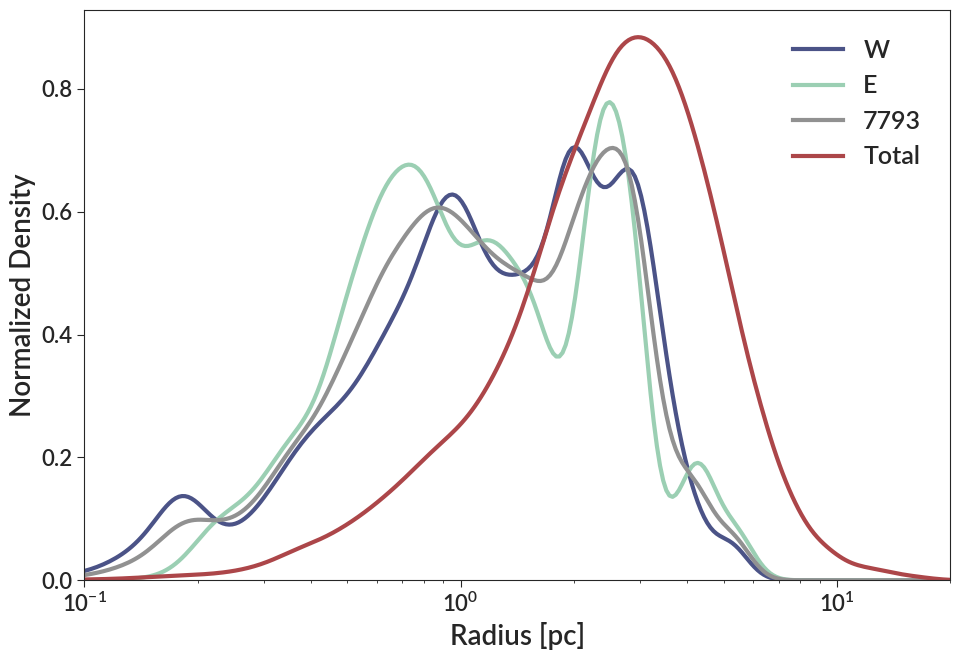

In [11]:
fig, ax = bpl.subplots()
xs = np.logspace(-1, 1.5, 300)
ax.plot(xs, kde(xs, big_catalog["r_eff_log"][mask_w], big_catalog["r_eff_logerr_smooth"][mask_w]), label="W")
ax.plot(xs, kde(xs, big_catalog["r_eff_log"][mask_e], big_catalog["r_eff_logerr_smooth"][mask_e]), label="E")
ax.plot(xs, kde(xs, big_catalog["r_eff_log"][mask_ew], big_catalog["r_eff_logerr_smooth"][mask_ew]), label="7793")
ax.plot(xs, kde(xs, big_catalog["r_eff_log"], big_catalog["r_eff_logerr_smooth"]), label="Total")


ax.set_xscale("log")
ax.set_limits(0.1, 20, 0)
ax.legend()
ax.add_labels("Radius [pc]", "Normalized Density")

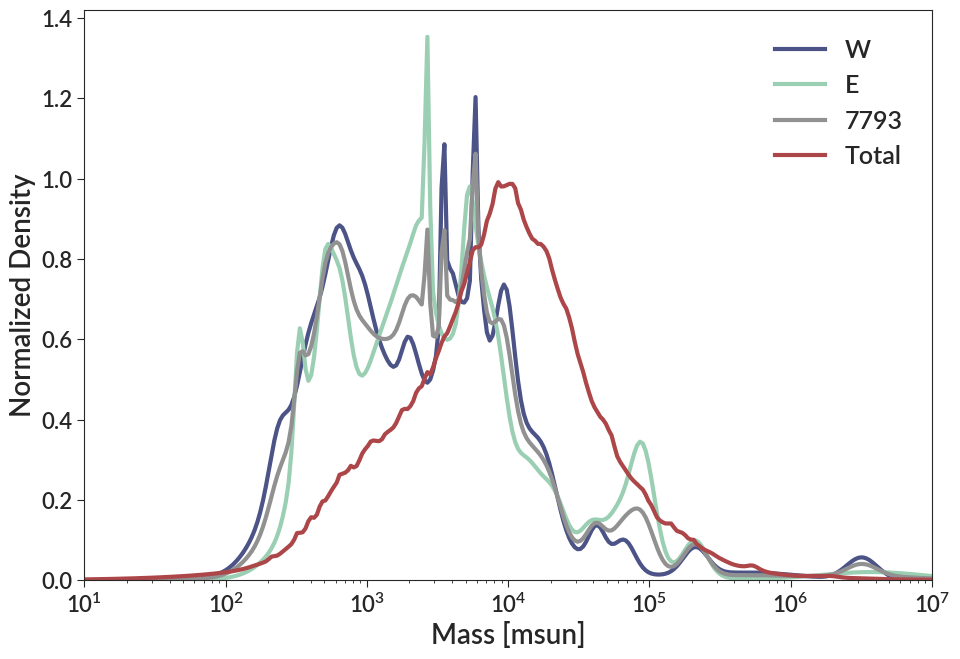

In [12]:
fig, ax = bpl.subplots()
xs = np.logspace(1, 7, 300)
ax.plot(xs, kde(xs, big_catalog["mass_log"][mask_w], big_catalog["mass_logerr_smooth"][mask_w]), label="W")
ax.plot(xs, kde(xs, big_catalog["mass_log"][mask_e], big_catalog["mass_logerr_smooth"][mask_e]), label="E")
ax.plot(xs, kde(xs, big_catalog["mass_log"][mask_ew], big_catalog["mass_logerr_smooth"][mask_ew]), label="7793")
ax.plot(xs, kde(xs, big_catalog["mass_log"], big_catalog["mass_logerr_smooth"]), label="Total")

ax.set_xscale("log")
ax.set_limits(10, 1e7, 0)
ax.legend()
ax.add_labels("Mass [msun]", "Normalized Density")

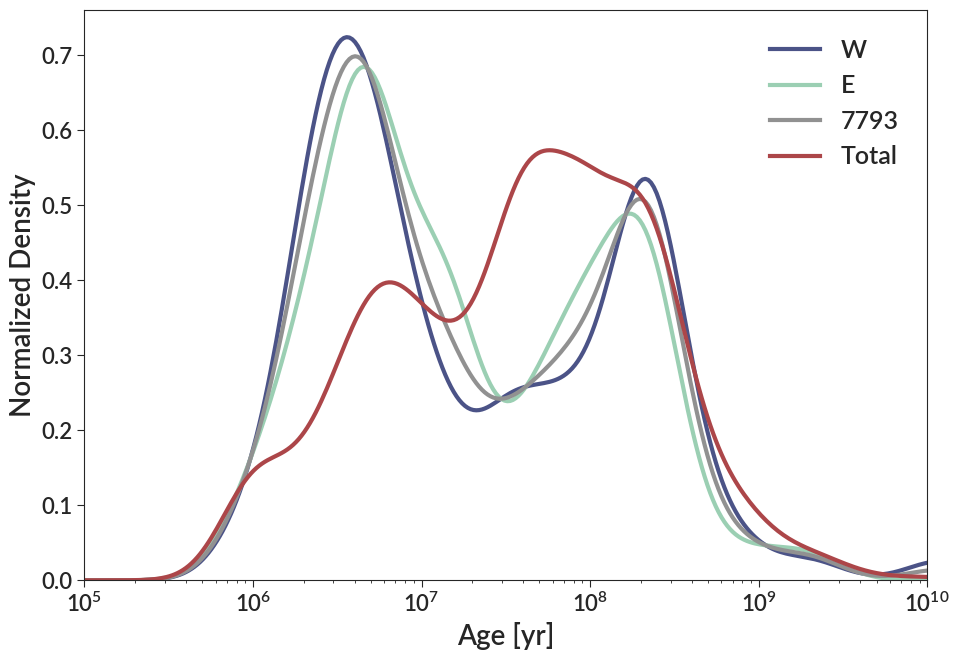

In [13]:
fig, ax = bpl.subplots()
xs = np.logspace(5, 10, 300)
ax.plot(xs, kde(xs, big_catalog["age_log"][mask_w], big_catalog["age_logerr_smooth"][mask_w]), label="W")
ax.plot(xs, kde(xs, big_catalog["age_log"][mask_e], big_catalog["age_logerr_smooth"][mask_e]), label="E")
ax.plot(xs, kde(xs, big_catalog["age_log"][mask_ew], big_catalog["age_logerr_smooth"][mask_ew]), label="7793")
ax.plot(xs, kde(xs, big_catalog["age_log"], big_catalog["age_logerr_smooth"]), label="Total")

ax.set_xscale("log")
ax.set_limits(1e5, 1e10, 0)
ax.legend()
ax.add_labels("Age [yr]", "Normalized Density")

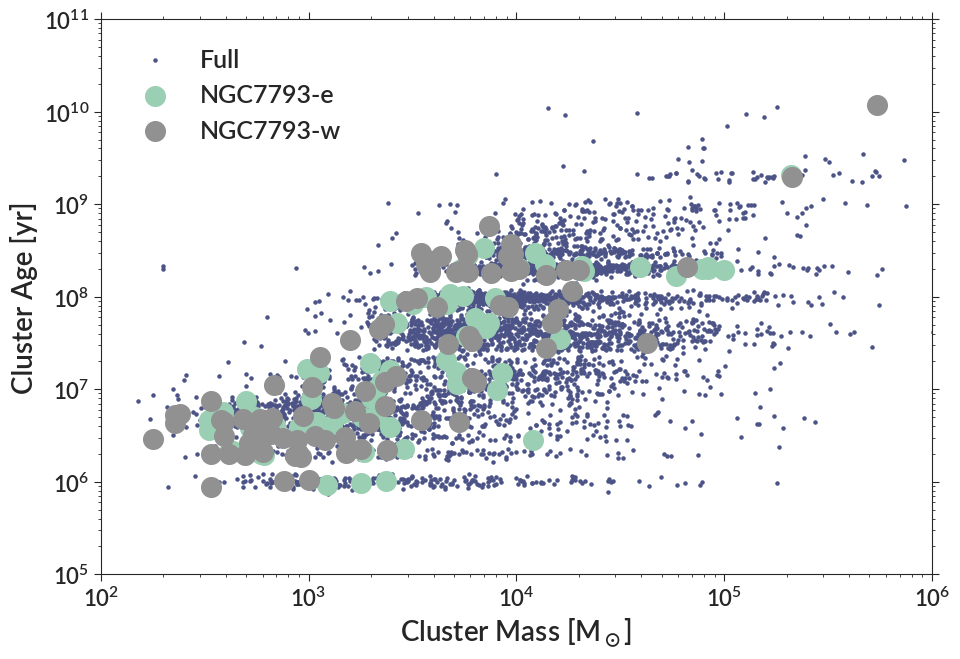

In [14]:
fig, ax = bpl.subplots()
# add some scatter to the ages for visual purposes
plot_ages = big_catalog["age_yr"] * np.random.normal(1, 0.08, len(big_catalog))

ax.scatter(big_catalog["mass_msun"], 
           plot_ages,
           s=5, alpha=1, label='Full')
ax.scatter(big_catalog["mass_msun"][mask_e], 
           plot_ages[mask_e], 
           s=200, alpha=1, label="NGC7793-e")
ax.scatter(big_catalog["mass_msun"][mask_w], 
           plot_ages[mask_w], 
           s=200, alpha=1, label="NGC7793-w")


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_limits(1e2, 1e6, 1e5, 1e11)
ax.add_labels("Cluster Mass [M$_\odot$]", "Cluster Age [yr]")
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.legend(loc=2, frameon=False)


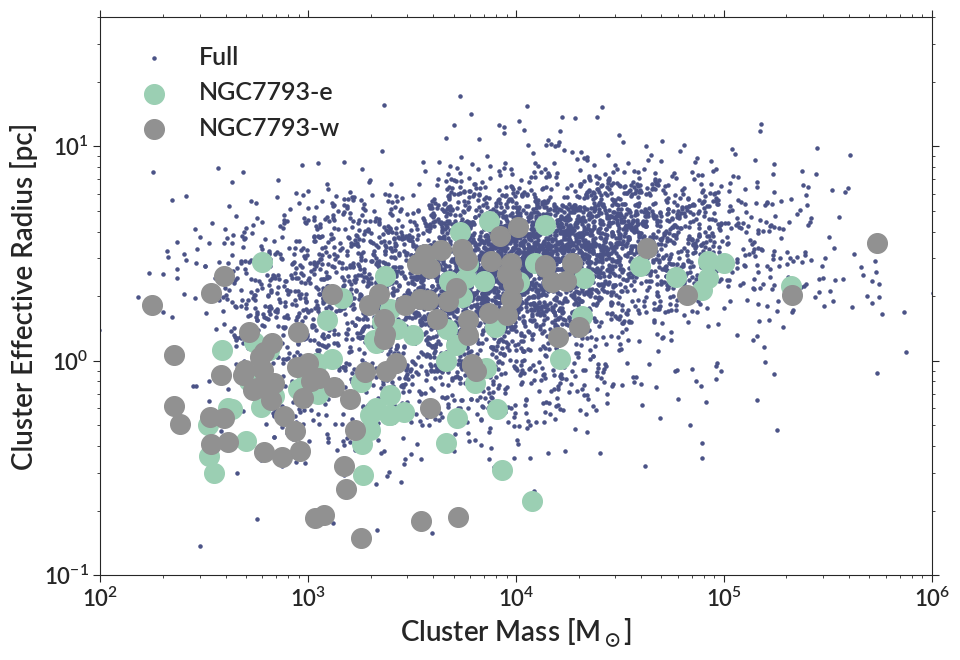

In [15]:
fig, ax = bpl.subplots()
ax.scatter(big_catalog["mass_msun"], 
           big_catalog["r_eff_pc"], 
           s=5, alpha=1, label='Full')
ax.scatter(big_catalog["mass_msun"][mask_e], 
           big_catalog["r_eff_pc"][mask_e], 
           s=200, alpha=1, label="NGC7793-e")
ax.scatter(big_catalog["mass_msun"][mask_w], 
           big_catalog["r_eff_pc"][mask_w], 
           s=200, alpha=1, label="NGC7793-w")


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_limits(1e2, 1e6, 0.1, 40)
ax.add_labels("Cluster Mass [M$_\odot$]", "Cluster Effective Radius [pc]")
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.legend(loc=2, frameon=False)
    

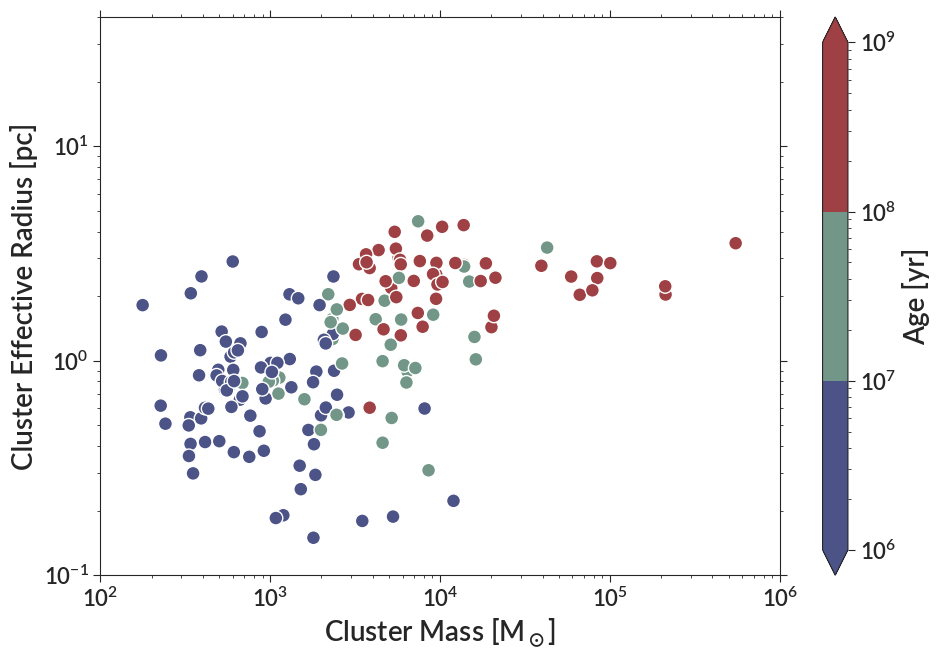

In [16]:
cmap = colors.ListedColormap(colors=[bpl.color_cycle[0], "#729788", "#9F4144"], name="")
norm = colors.LogNorm(vmin=1e6, vmax=1e9)
mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
age_colors = mappable.to_rgba(big_catalog["age_yr"])

fig, ax = bpl.subplots()


# ax.scatter(big_catalog["mass_msun"], 
#            big_catalog["r_eff_pc"], 
#            s=5, alpha=1, color=age_colors)
ax.scatter(big_catalog["mass_msun"][mask_ew], 
           big_catalog["r_eff_pc"][mask_ew],
           color=age_colors[mask_ew],
           s=100, alpha=1, edgecolor="w", lw=1)



ax.set_xscale("log")
ax.set_yscale("log")
ax.set_limits(1e2, 1e6, 0.1, 40)
ax.add_labels("Cluster Mass [M$_\odot$]", "Cluster Effective Radius [pc]")
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
cbar = fig.colorbar(mappable, ax=ax, extend="both")
cbar.set_label("Age [yr]")

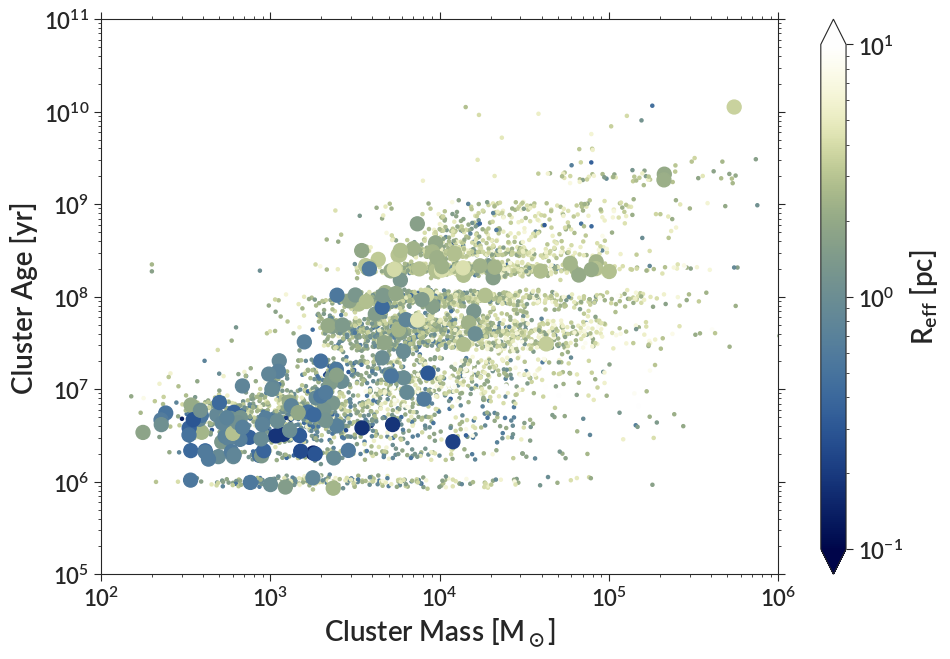

In [17]:
cmap = bpl.cm.davos
norm = colors.LogNorm(vmin=0.1, vmax=10)
mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
r_eff_colors = mappable.to_rgba(big_catalog["r_eff_pc"])

fig, ax = bpl.subplots()
# add some scatter to the ages for visual purposes
plot_ages = big_catalog["age_yr"] * np.random.normal(1, 0.08, len(big_catalog))

ax.scatter(big_catalog["mass_msun"], 
           plot_ages,
           s=5, alpha=1, c=r_eff_colors)
ax.scatter(big_catalog["mass_msun"][mask_ew], 
           plot_ages[mask_ew], 
           s=100, alpha=1, c=r_eff_colors[mask_ew])


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_limits(1e2, 1e6, 1e5, 1e11)
ax.add_labels("Cluster Mass [M$_\odot$]", "Cluster Age [yr]")
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
cbar = fig.colorbar(mappable, ax=ax, extend="both")
cbar.set_label("$R_{\\rm eff}$ [pc]")




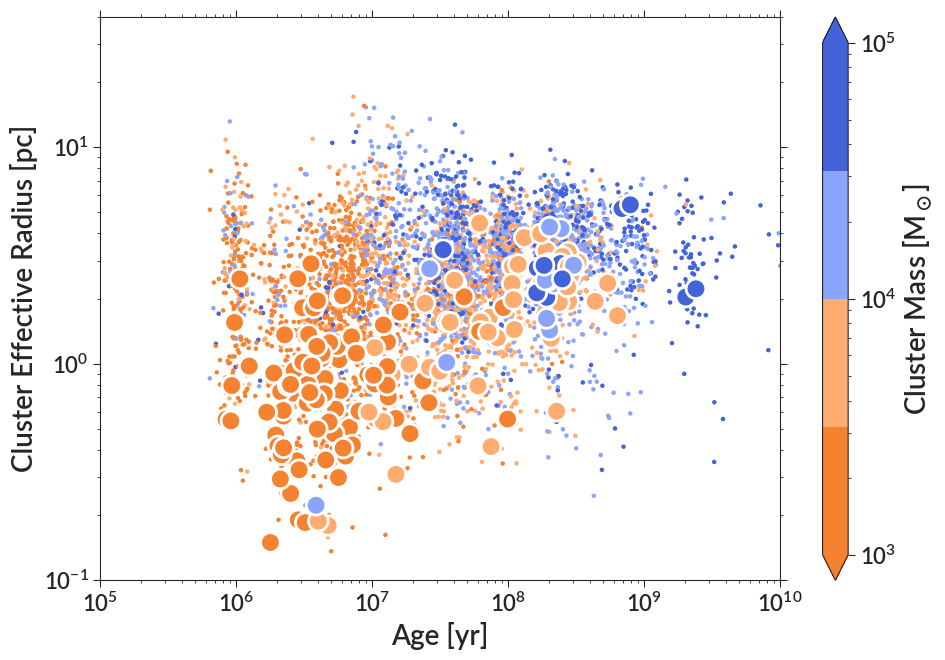

In [18]:
cmap_colors = ["#f58231", "#FFAC71", "#8BA4FD", "#4363d8"]
cmap = colors.ListedColormap(colors=cmap_colors, name="")
norm = colors.LogNorm(vmin=1e3, vmax=1e5)
mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
mass_colors = mappable.to_rgba(big_catalog["mass_msun"])

fig, ax = bpl.subplots()

ax.scatter(big_catalog["age_yr"] * np.random.normal(1, 0.15, len(big_catalog)), 
           big_catalog["r_eff_pc"], 
           s=5, alpha=1, color=mass_colors)
ax.scatter(big_catalog["age_yr"][mask_ew] * np.random.normal(1, 0.15, np.sum(mask_ew)), 
           big_catalog["r_eff_pc"][mask_ew],
           color=mass_colors[mask_ew],
           s=200, alpha=1, edgecolor="w", lw=2)



ax.set_xscale("log")
ax.set_yscale("log")
ax.set_limits(1e5, 1e10, 0.1, 40)
ax.add_labels("Age [yr]", "Cluster Effective Radius [pc]")
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
cbar = fig.colorbar(mappable, ax=ax, extend="both")
cbar.set_label("Cluster Mass [M$_\odot$]")
fig.savefig("ngc7793_age_radius.png")

# Now examine the clusters in the galaxy

In [19]:
image_7793e = utils.get_drc_image(data_dir / "ngc7793-e")[0]
image_7793w = utils.get_drc_image(data_dir / "ngc7793-w")[0]

In [20]:
all_mask_e = all_catalog["galaxy"] == "ngc7793-e"
all_mask_w = all_catalog["galaxy"] == "ngc7793-w"
all_mask_ew = np.logical_or(all_mask_e, all_mask_w)
split = np.median(all_catalog["r_eff_pc"][all_mask_ew])

/Users/gillenb/miniconda3/envs/legus/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/gillenb/miniconda3/envs/legus/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


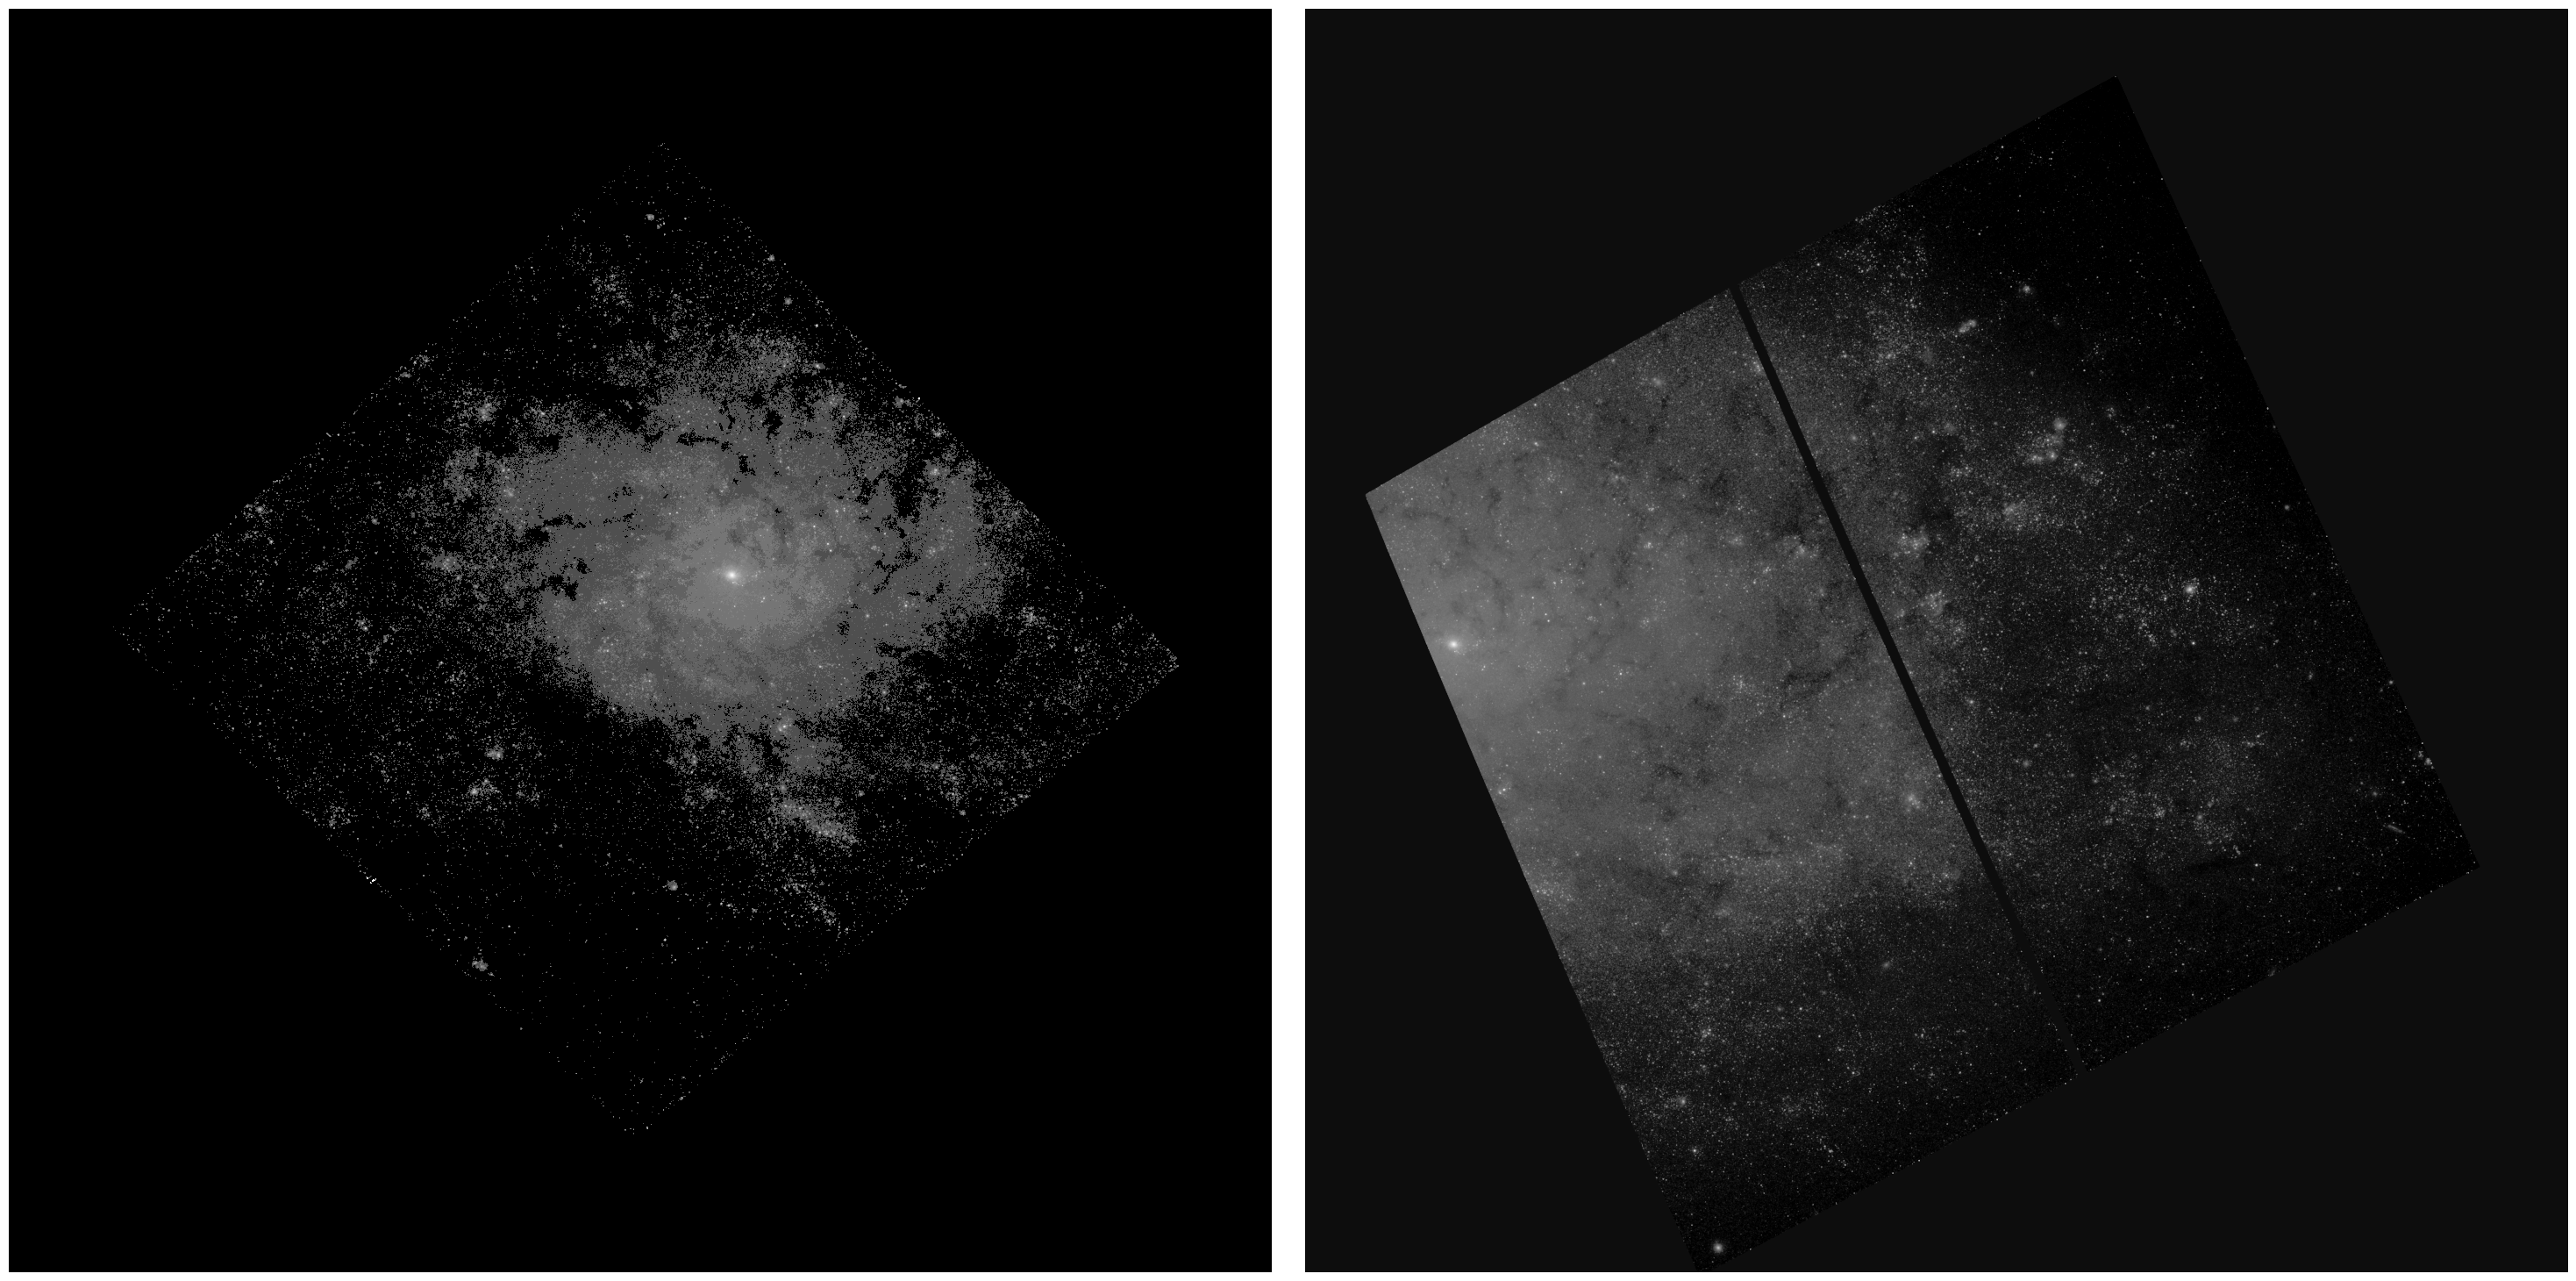

In [21]:
fig, axs = bpl.subplots(figsize=[30, 15], ncols=2)
norm = colors.SymLogNorm(linthresh=10, linscale=0.2, vmin=-10, vmax=1e5, base=10)
axs[0].imshow(image_7793e, norm=norm, cmap="Greys_r")
axs[1].imshow(image_7793w, norm=norm, cmap="Greys_r")
axs[0].axis("off")
axs[1].axis("off")



# then add clusters
for row in all_catalog:
    if row['galaxy'] == "ngc7793-e":
        ax=axs[0]
    elif row["galaxy"] == "ngc7793-w":
        ax=axs[1]
    else:
        continue
        
    if row["r_eff_pc_rmax_15pix_best"] < split:
        color = bpl.color_cycle[1]
    else:
        color = bpl.color_cycle[4]
        
    ax.scatter(row["x"], row["y"], c="none", edgecolors=color, facecolors="none", 
               s=15, lw=0.6)
    ax.add_text(x=row["x"], y=row["y"]-10, 
                text=f"{row['r_eff_pc_rmax_15pix_best']:.2f}pc",
                color=color, fontsize=5,
                ha="center", va="bottom")

fig.savefig("ngc7793.png", dpi=500)